In [39]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from PIL import Image
import tensorflow as tf



In [40]:
# 1. Load the saved model (.keras)
model = tf.keras.models.load_model('my_model_VGG16_reducelr_1e-5.keras')
print("Model loaded successfully!")




Model loaded successfully!


In [41]:
# 2. Read the CSV with image paths and product type codes
df = pd.read_csv('preprocessed_image_train.csv')
df = df[['image_path', 'prdtypecode']]  # Keep only relevant columns
df.head()

,image_path,prdtypecode
0,C:/Users/User/OneDrive - ingenium digital diag...,10
1,C:/Users/User/OneDrive - ingenium digital diag...,2280
2,C:/Users/User/OneDrive - ingenium digital diag...,2403
3,C:/Users/User/OneDrive - ingenium digital diag...,1160
4,C:/Users/User/OneDrive - ingenium digital diag...,1160


In [42]:
# 3. Function to preprocess the image for the model
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess as per VGG16 requirements
    return img_array

In [43]:
# 4. Function to compute Grad-CAM
def grad_cam(model, img_array, class_idx):
    # Ensure the input image array is a tf.Tensor
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Get the last convolutional layer in the model
    last_conv_layer = model.get_layer('block5_conv3')  # Adapt to your model architecture
    
    # Create a model that outputs the gradients of the last convolutional layer w.r.t the class index
    grad_model = tf.keras.Model([model.input], [last_conv_layer.output, model.output])
    
    # Record gradients for backpropagation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(img_array)
        
        # Get the output of the last convolutional layer and the predictions
        conv_output, predictions = grad_model(img_array)
        
        # Get the class gradient for the given class index
        class_output = predictions[:, class_idx]
    
    # Get the gradients with respect to the last convolutional layer
    grads = tape.gradient(class_output, conv_output)
    
    # Compute the mean intensity of the gradients across each filter
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map array by the corresponding gradients
    conv_output = conv_output[0]  # Remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Apply ReLU activation to the heatmap and normalize
    heatmap = tf.maximum(heatmap, 0)  # Remove negative values
    heatmap /= tf.reduce_max(heatmap)  # Normalize to [0, 1]
    return heatmap.numpy()

In [44]:
# 5. Function to overlay the heatmap on the image
def overlay_heatmap_on_image(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = Image.open(img_path)  # Load the image using PIL
    img = np.array(img)  # Convert to NumPy array

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Ensure the heatmap is in uint8 format
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Normalize to [0, 255]

    # Apply a colormap to the heatmap for visualization
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    if img.ndim == 2:  # If the image is grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    # Display the image with heatmap overlay
    plt.imshow(superimposed_img)
    plt.axis('off')  # Turn off axis
    plt.show()


Processing product code: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


c:\Users\User\OneDrive - ingenium digital diagnostics GmbH\Desktop\DataScientest\Rakuten project\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


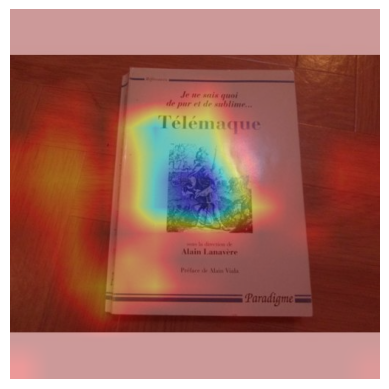

Processing product code: 2280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


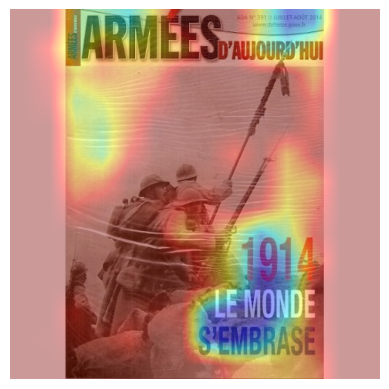

Processing product code: 2403
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


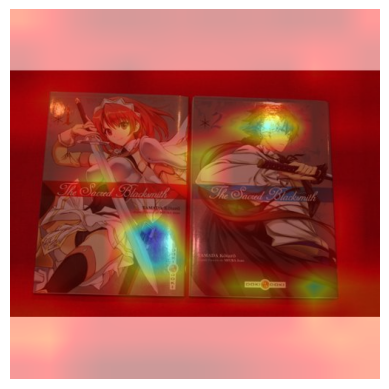

Processing product code: 1160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


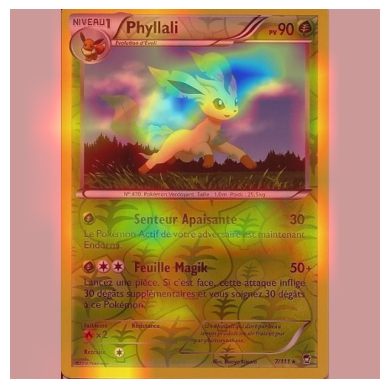

Processing product code: 1320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


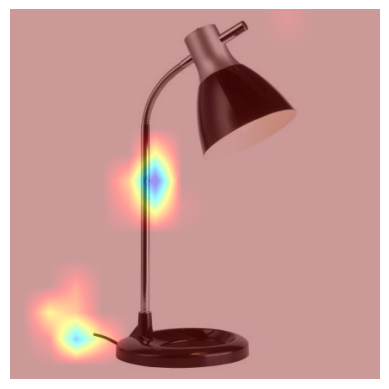

Processing product code: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


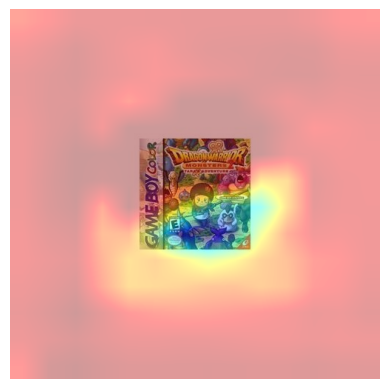

Processing product code: 2522
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


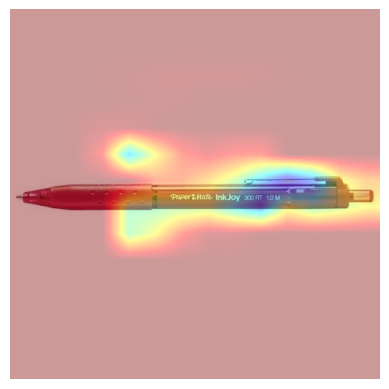

Processing product code: 1281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


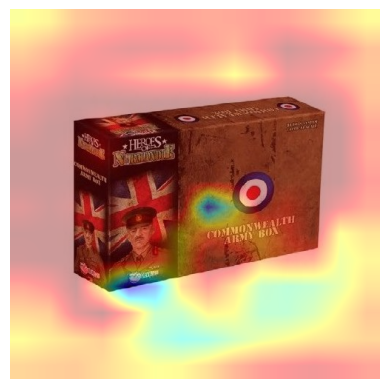

Processing product code: 1920
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


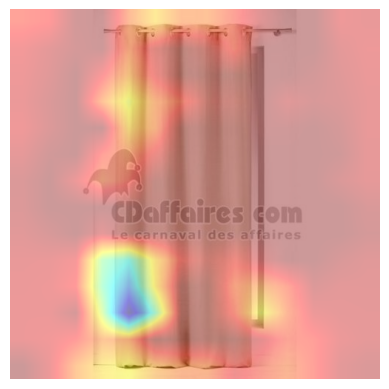

Processing product code: 2583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


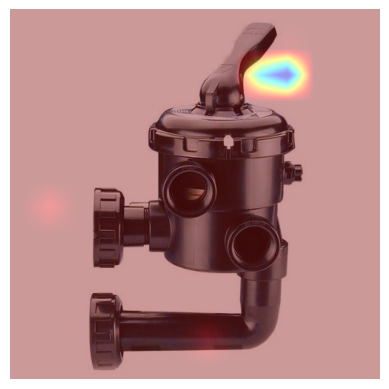

Processing product code: 1302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


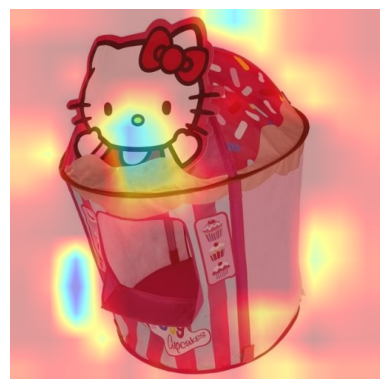

Processing product code: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


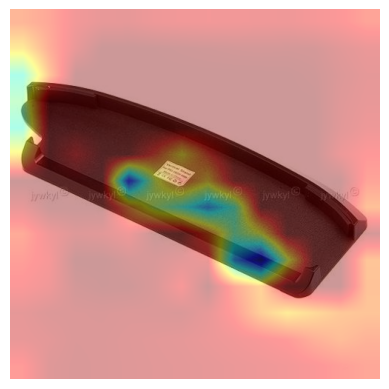

Processing product code: 2462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


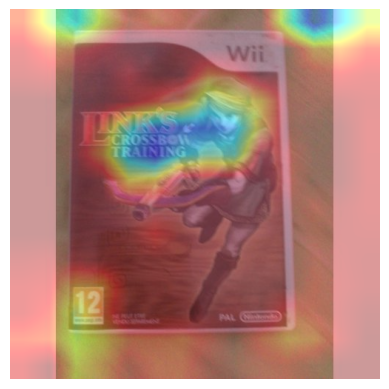

Processing product code: 2705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


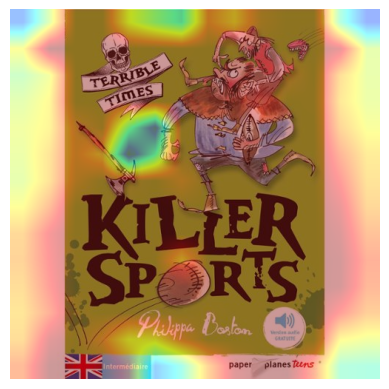

Processing product code: 1301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


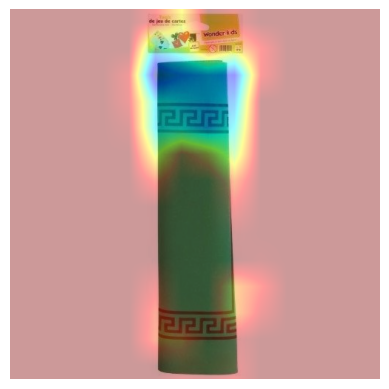

Processing product code: 1140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


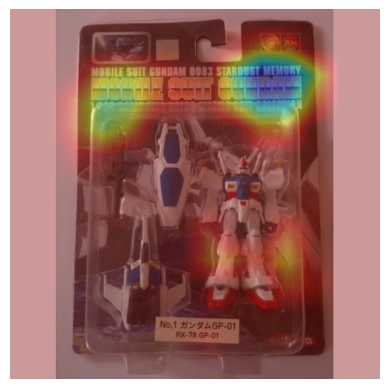

Processing product code: 1940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


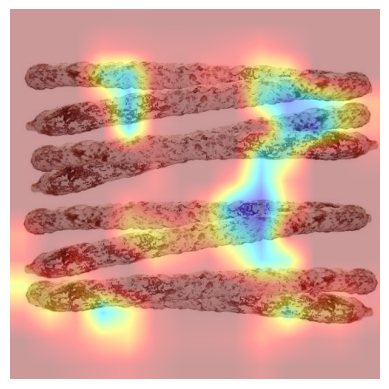

Processing product code: 2060
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


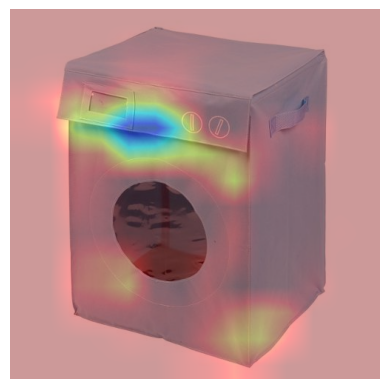

Processing product code: 1280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


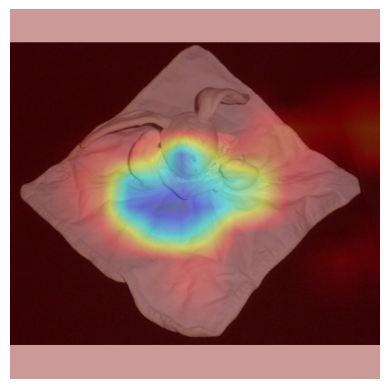

Processing product code: 2582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


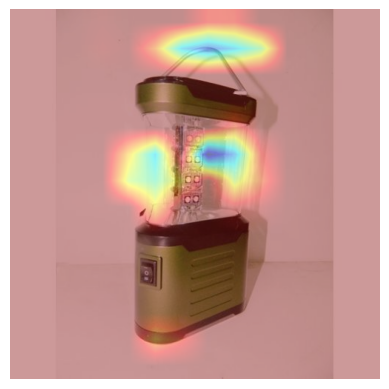

Processing product code: 2585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_13604\2626267654.py:11: RuntimeWarning: invalid value encountered in cast
  heatmap_resized = np.uint8(255 * heatmap_resized)  # Normalize to [0, 255]


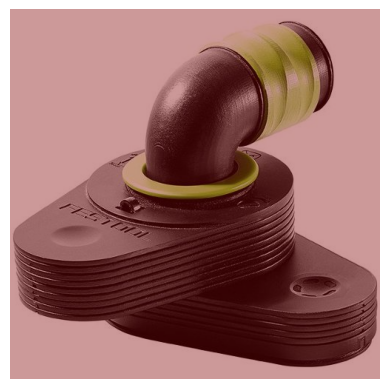

Processing product code: 1180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


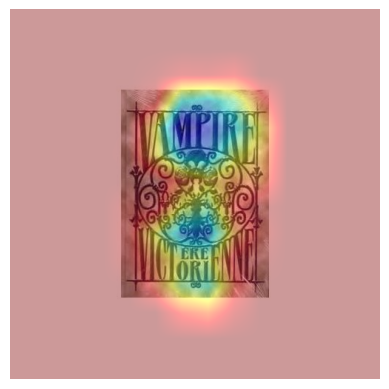

Processing product code: 1560
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


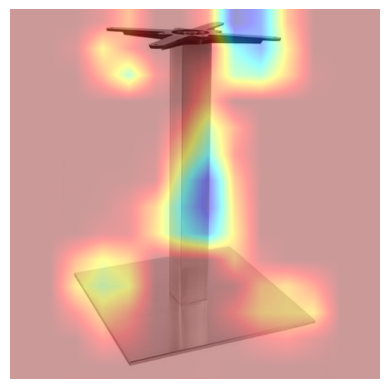

Processing product code: 1300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


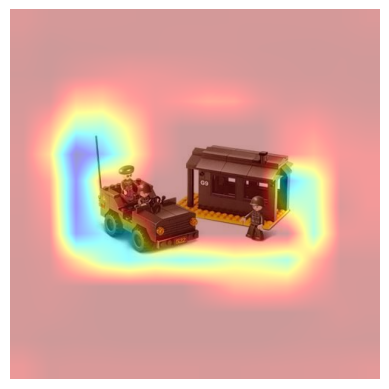

Processing product code: 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


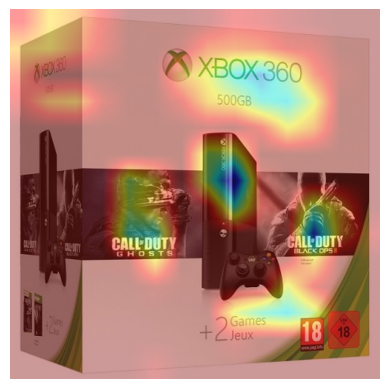

Processing product code: 2220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


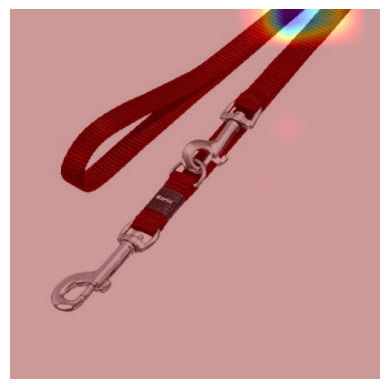

Processing product code: 2905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


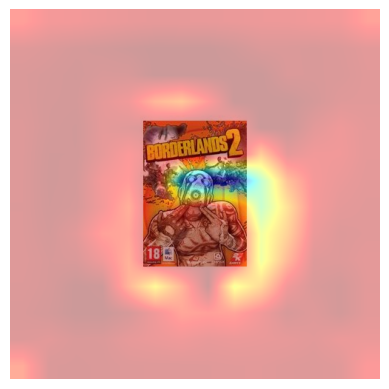

In [45]:
# 6. Process one image per product type code and generate Grad-CAM images
product_codes = df['prdtypecode'].unique()  # Get unique product codes from the dataframe

for product_code in product_codes:
    print(f"Processing product code: {product_code}")
    
    # Filter DataFrame for the current product code and take the first image
    product_image = df[df['prdtypecode'] == product_code].iloc[0]
    
    img_path = product_image['image_path']
    
    try:
        # Preprocess the image for prediction
        img_array = preprocess_image(img_path)
        
        # Get predictions from the model
        predictions = model.predict(img_array)
        class_idx = np.argmax(predictions[0])  # Get the predicted class index
        
        # Generate Grad-CAM heatmap
        heatmap = grad_cam(model, img_array, class_idx)
        
        # Overlay the heatmap on the image
        overlay_heatmap_on_image(img_path, heatmap)
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")